In [1]:
#load libraries
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import timm
import pandas as pd
import numpy as np
import dataset 
from os import listdir
import matplotlib.pyplot as plt
from datetime import datetime

c:\Users\lover37\OneDrive - Université Laval\Documenten_Loes\Development\CNN_SVI_pred_Sina\virtualenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#open trained model - I only use one fold - ensemble learning could also be applied 

network_fold_9='trained_model/666_10_9_convnext_nano_0.0001_30_batch32_SVI_TRANSFERLEARNING.pk_NETWORK.pt'

model = timm.create_model( #load convnext_nano model
    'convnext_nano', 
    pretrained=False,  # Set to False because we're loading custom trained weights
    num_classes=1, 
    head_init_scale=0.001, 
    drop_path_rate=0.1
)

model.load_state_dict(torch.load(network_fold_9, map_location=torch.device('cpu'))) #load trained weights and biases

C:\Users\lover37\AppData\Local\Temp\ipykernel_24572\1406308472.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(network_fold_9, map_loca

<All keys matched successfully>

In [3]:
#load data and preprocess images
imgdimm = (384, 512)
averages =  (0.485, 0.456, 0.406)
variances = (0.229, 0.224, 0.225)  

val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(imgdimm),
        transforms.Normalize(averages, variances),        
    ])

all_data = dataset.MicroscopicImages(root='data/microscopic_images_4x', transform=val_transform, label='SVI') 

testloader = torch.utils.data.DataLoader(all_data, batch_size = 1, shuffle = False, drop_last=False) #batch size can be 1 during testing

data/microscopic_images_4x/2024-10-02
02-10-2024 at 4x CRWRRF  2.JPG
02-10-2024 at 4x CRWRRF 1.JPG
data/microscopic_images_4x/2024-10-04
04-10-2024 at 4x CRWRRF  3.JPG
04-10-2024 at 4x CRWRRF  4.JPG
04-10-2024 at 4x CRWRRF  5.JPG
04-10-2024 at 4x CRWRRF  6.JPG
data/microscopic_images_4x/2024-10-06
06-10-2024 at 4x CRWRRF  10.JPG
06-10-2024 at 4x CRWRRF  11.JPG
06-10-2024 at 4x CRWRRF  7.JPG
06-10-2024 at 4x CRWRRF  8.JPG
06-10-2024 at 4x CRWRRF  9.JPG
data/microscopic_images_4x/2024-10-08
08-10-2024 at 4x CRWRRF  12.JPG
08-10-2024 at 4x CRWRRF  13.JPG
08-10-2024 at 4x CRWRRF  14.JPG
08-10-2024 at 4x CRWRRF  15.JPG
08-10-2024 at 4x CRWRRF  16.JPG
data/microscopic_images_4x/2024-10-10
10-10-2024 at 4x CRWRRF  17.JPG
10-10-2024 at 4x CRWRRF  18.JPG
10-10-2024 at 4x CRWRRF  19.JPG
10-10-2024 at 4x CRWRRF  20.JPG
10-10-2024 at 4x CRWRRF  21.JPG
data/microscopic_images_4x/2024-10-14
14-10-2024 at 4x CRWRRF  22.JPG
14-10-2024 at 4x CRWRRF  23.JPG
14-10-2024 at 4x CRWRRF  24.JPG
14-10-2024 at 

In [ ]:
#make predictions with pretrained model
TARGET_SCALE = 440 #this target scale is estimated from Sina's data since I don't have the real target scale available

predictions = []

with torch.no_grad():  # Disable gradient calculation
    for data in testloader:
        inputs, labels = data[0], data[1].to(torch.float32)
        labels = labels.unsqueeze(1)

        output=model(inputs)
                    
        predictions.append((labels.numpy()[0], output.numpy()[0,0]*TARGET_SCALE))

In [17]:
predictions[0][1]

np.float32(235.11507)

Now every image predicts one SVI value, so average of every image label prediction needs to be calculated per sample date

In [20]:
### calc average SVI
base_folder = 'data/microscopic_images_4x'
image_folders = listdir(base_folder) 

average_SVIs = []
i=0
for folder in image_folders:
    path = f"{base_folder}/{folder}"
    images_list = listdir(path)
    temporary=[]
    for image in images_list:
        pred = predictions[i][1]
        i+=1
        temporary.append(pred)
    average_SVIs.append(sum(temporary)/len(temporary))

In [32]:
dates = [datetime.strptime(date, '%Y-%m-%d') for date in image_folders]
dates

[datetime.datetime(2024, 10, 2, 0, 0),
 datetime.datetime(2024, 10, 4, 0, 0),
 datetime.datetime(2024, 10, 6, 0, 0),
 datetime.datetime(2024, 10, 8, 0, 0),
 datetime.datetime(2024, 10, 10, 0, 0),
 datetime.datetime(2024, 10, 14, 0, 0),
 datetime.datetime(2024, 10, 17, 0, 0),
 datetime.datetime(2024, 10, 21, 0, 0),
 datetime.datetime(2024, 10, 23, 0, 0),
 datetime.datetime(2024, 10, 25, 0, 0),
 datetime.datetime(2024, 10, 28, 0, 0),
 datetime.datetime(2024, 10, 30, 0, 0)]

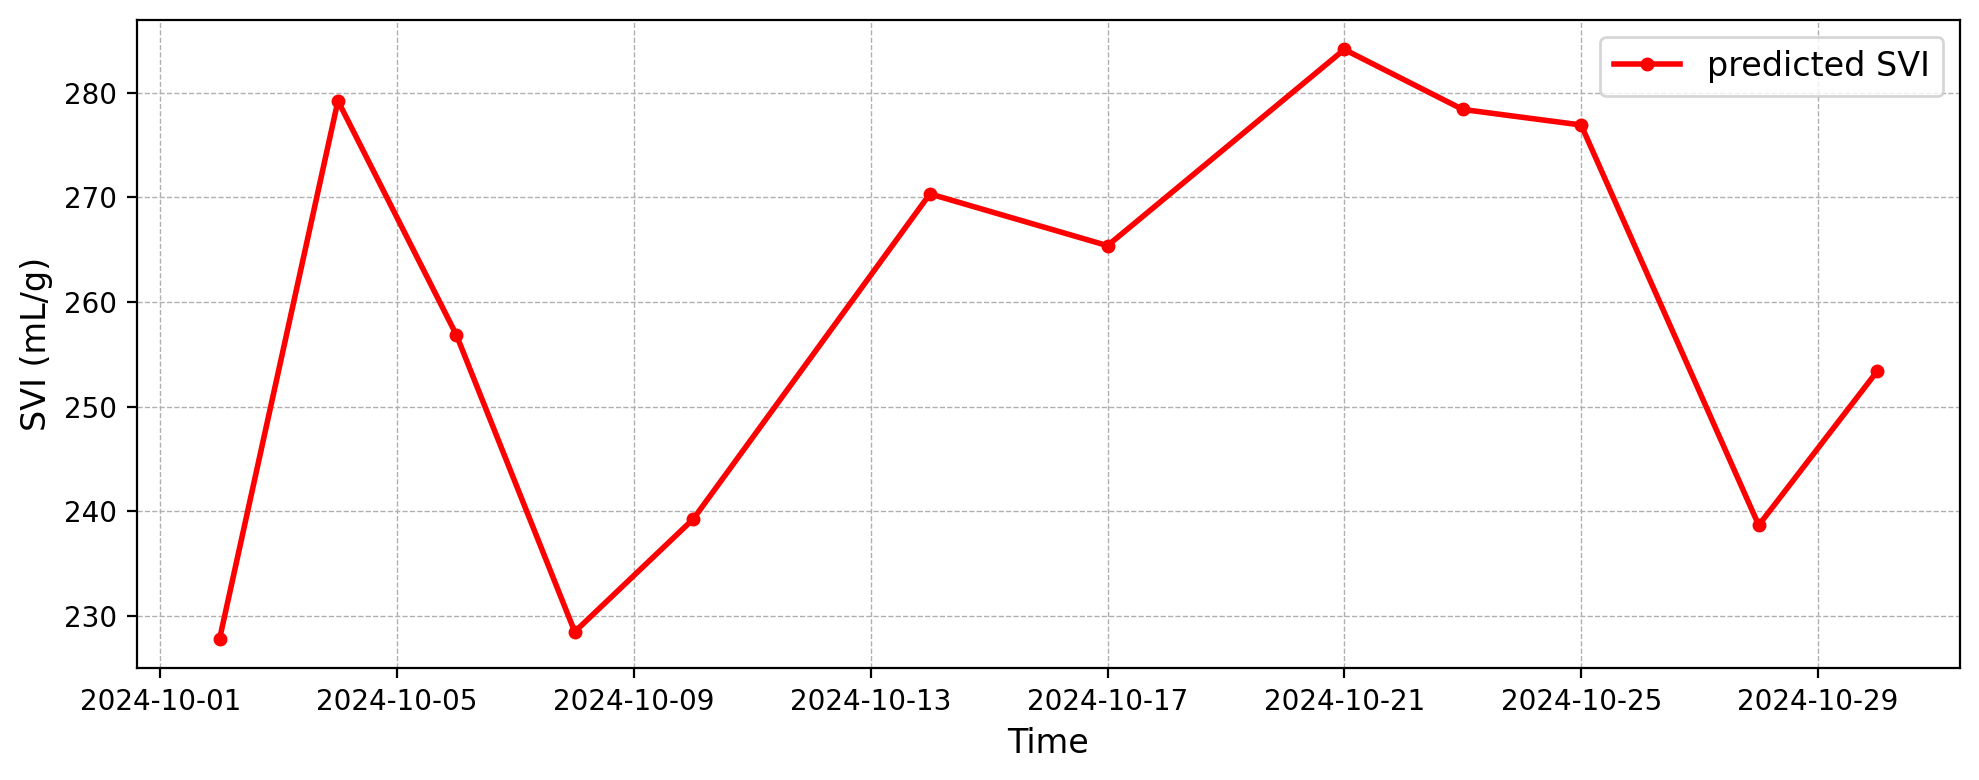

In [38]:
## Plot SVI
plt.figure(figsize=(10,4),dpi=200)
#plt.plot(measured_SVIs, '-o', color='b', markersize=4, linewidth=2, label='measured SSVI')
plt.plot(dates, average_SVIs, '-o', color='r', markersize=4, linewidth=2, label='predicted SVI')
plt.xlabel('Time', fontsize=12)
plt.ylabel('SVI (mL/g)', fontsize=12)
#plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [41]:
# Save data in an excel file
data = pd.DataFrame({
    'Date': dates,
    'predicted_SVI': average_SVIs
})

data.to_excel('svi_data.xlsx', index=False) 